<a href="https://colab.research.google.com/github/AnnaGass/DSA-SleepHealthData/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Select the subject to be used

subject = '017'

# Install python libraries and load packages

In [2]:
# @title Install needed libraries { display-mode: "form" }
!pip install pyedflib
!pip install pandas

In [3]:
# @title Import libraries
import subprocess
import pyedflib
import csv
import os

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from datetime import timedelta
from datetime import datetime

# Import data

In [4]:
# @title Import the data from physionet

rec_path = "https://physionet.org/files/ucddb/1.0.0/ucddb" + subject + ".rec"
sleep_annotation_path = "https://physionet.org/files/ucddb/1.0.0/ucddb" + subject + "_stage.txt"
apnea_annotation_path = "https://physionet.org/files/ucddb/1.0.0/ucddb" + subject + "_respevt.txt"

command = "wget -r -N -c -np " + rec_path
result = subprocess.run(command, shell=True, capture_output=True, text=True)

command = "wget -r -N -c -np " + sleep_annotation_path
result = subprocess.run(command, shell=True, capture_output=True, text=True)

command = "wget -r -N -c -np " + apnea_annotation_path
result = subprocess.run(command, shell=True, capture_output=True, text=True)

# Prepare the data

In [5]:
# @title Extract signals from .rec file - <em>results/subject[XXX]_signals.csv<em>

spo2_index = 6      # taken from the headers
pulse_index = 13    # taken from the headers

# Initialize an empty list to store your values
data = []

# open the file
path = "/content/physionet.org/files/ucddb/1.0.0/ucddb" + subject + ".rec"
f = pyedflib.EdfReader(path)

# file properties
start_time = f.getStartdatetime()
file_duration = f.getFileDuration()
signal_labels = f.getSignalLabels()

# SpO2 information
spo2_header = f.getSignalHeader(spo2_index)
spo2_signals = f.readSignal(spo2_index)

# Pulse information
pulse_header = f.getSignalHeader(pulse_index)
pulse_signals = f.readSignal(pulse_index)

# Calculate frequency
time_between_meassurements = file_duration / len(pulse_signals)

# Iterate and add the increment to the datetime on each iteration
for i in range(len(pulse_signals)):
    data.append([start_time, spo2_signals[i], pulse_signals[i]])
    start_time += timedelta(seconds=time_between_meassurements)

# Specify the file name
csv_file = "results/subject" + subject + "_signals.csv"

# Create results folder if not exists
if not os.path.exists("results"):
    # Create the folder
    os.makedirs("results")

# Write the data to a CSV file
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(data)

f.close()

In [6]:
# @title Transform apnea annotation txt to csv - <em>results/subject[XXX]_apnea_anno.csv<em>

# Specify the input file name
input_txt = "/content/physionet.org/files/ucddb/1.0.0/ucddb" + subject + "_respevt.txt"

# Specify the output file name
output_csv = "results/subject" + subject + "_apnea_anno.csv"
output_csv_extra = "results/subject" + subject + "_apnea_anno_extra.csv"

# Open the input file
with open(input_txt, 'r') as infile:
    # Skip the first two lines (header)
    next(infile)
    next(infile)
    next(infile)

     # Open a CSV file for writing with more parameters
    with open(output_csv, 'w', newline='') as outfile:
        writer = csv.writer(outfile)

        # Write the header
        writer.writerow(['Time', 'Type'])

        # Process each line in the input file
        for line in infile:
            # Split the line into columns
            columns = line.split()

            # Check if the line has enough columns
            if len(columns) >= 5:
                # Extract the required columns
                time_str = columns[0]
                event_type = columns[1]
                duration_str = columns[2]

                # Parse duration into seconds
                duration_seconds = int(duration_str)

                # Parse time string into datetime object
                time = datetime.strptime(time_str, '%H:%M:%S')

                # Iterate over the duration and add one second to the time in each iteration
                for _ in range(duration_seconds):
                    # Write the time, event type, and duration to the CSV file
                    writer.writerow([time.strftime('%H:%M:%S'), event_type])

                    # Add one second to the time
                    time += timedelta(seconds=1)
        outfile.close()
infile.close()

# Open the input file
with open(input_txt, 'r') as infile:
    # Skip the first two lines (header)
    next(infile)
    next(infile)
    next(infile)
    # Open a CSV file for writing with more parameters
    with open(output_csv_extra, 'w', newline='') as outfile_extra:
        writer = csv.writer(outfile_extra)

        # Write the header
        writer.writerow(['Time', 'Type', 'Snore', 'Arousal'])

        # Process each line in the input file
        for line in infile:
            # Split the line into columns
            columns = line.split()

            # Check if the line has enough columns
            if len(columns) >= 5:
                # Extract the required columns
                time_str = columns[0]
                event_type = columns[1]
                duration_str = columns[2]

                if len(columns) == 5:
                  snore = columns[3]
                  arousal = columns[4]
                else:
                  snore = columns[5]
                  arousal = columns[6]

                snore_bool = False if snore == '-' else True
                arousal_bool = False if arousal == '-' else True

                # Parse duration into seconds
                duration_seconds = int(duration_str)

                # Parse time string into datetime object
                time = datetime.strptime(time_str, '%H:%M:%S')

                # Iterate over the duration and add one second to the time in each iteration
                for _ in range(duration_seconds):
                    # Write the time, event type, and duration to the CSV file
                    writer.writerow([time.strftime('%H:%M:%S'), event_type, snore_bool, arousal_bool])

                    # Add one second to the time
                    time += timedelta(seconds=1)

# Data Analysis

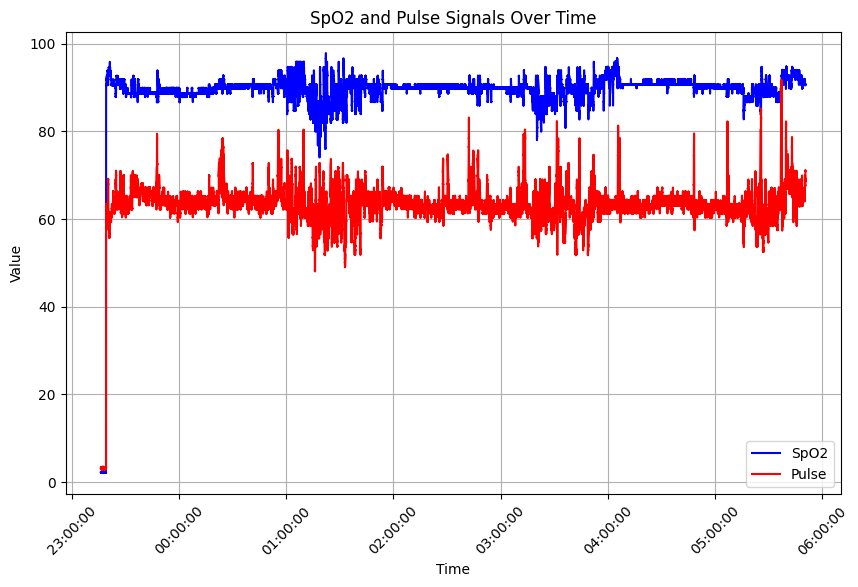

In [7]:
# @title Plot the signals from subject
# Load CSV data into a DataFrame assuming the order of columns is timestamp, spo2, and pulse
df = pd.read_csv(csv_file, header=None)

# Assuming the columns are in order: timestamp, spo2, and pulse
timestamp = df.iloc[:, 0]
spo2 = df.iloc[:, 1]
pulse = df.iloc[:, 2]

# Parse each datetime string into a datetime object
datetime_objects = []
for dt_str in timestamp:
    try:
        # Try parsing with milliseconds
        dt_obj = datetime.strptime(dt_str, "%Y-%m-%d %H:%M:%S.%f")
    except ValueError:
        # If milliseconds are not present, parse without milliseconds
        dt_obj = datetime.strptime(dt_str, "%Y-%m-%d %H:%M:%S")
    datetime_objects.append(dt_obj)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(datetime_objects, spo2, label='SpO2', color='blue')
plt.plot(datetime_objects, pulse, label='Pulse', color='red')

plt.title('SpO2 and Pulse Signals Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Set the format of the x-axis ticks to display only the time part
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

plot_png = "results/subject_plot" + subject + ".png"

# Save the plot to a file
plt.savefig(plot_png)

# Show the plot
plt.show()
